# Importando los paquetes que vamos a usar

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Algoritmos de clusterizacion
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Para la anotacion de tipos
from typing import Callable, List

# Carga de los datos

In [2]:
base_path = "dataset/datos_hogar_2020.csv"
df_global = pd.read_csv(base_path)

# Funciones comunes a todos los casos de estudio

Definimos en esta sección las funciones que vamos a usar a lo largo de todos los casos de estudio:

## Funciones para calcular clusters

In [3]:
def compute_kmeans(df: pd.DataFrame, number_clusters: int = 3) -> np.array:
    """
    Dado un dataframe con los datos a clusterizar, calcula el vector con las
    etiquetas de la clusterizacion kmeans
    """
    
    kmeans = KMeans(n_clusters = number_clusters, random_state=0).fit(df)
    return kmeans.labels_

def compute_dbscan(df: pd.DataFrame, eps: float = 0.3, min_samples: int = 10) -> np.array:
    """
    Dado un dataframe con los datos a clusterizar, calcula el vector con las
    etiquetas de la clusterizacion dbscan
    """
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(df)
    return db.labels_

def add_clustering_labels(df: pd.DataFrame, clustering_function: Callable, parameters: dict(), new_label_name: str, exclude_columns: List[str] = None) -> pd.DataFrame:
    """
    Dado un dataframe y un algoritmo de clusterizacion con sus parametros, devuelve el dataframe al que
    hemos añadido una columna con las nuevas etiquetas del clustering. Con esto nos evitamos escribir
    esta funcion para cada tipo de algorito para clusterizar. Solo tenemos que cambiar ese parametro
    
    Podemos excluir columnas para que no se usen en la clusterizacion
    """
    
    # Filtramos las columnas del dataframe que se quieren exluir del computo
    new_df = df.copy()
    if exclude_columns is not None:
        new_df = df.drop(columns = exclude_columns)
    
    # Realizamos el calculo y añadimos las etiquetas
    labels = clustering_function(df, **parameters)
    new_df[new_label_name] = labels
    
    return new_df

# Filtrado previo del dataset global

Definimos en variables todas las columnas que, al leer el documento explicando el *dataset*, nos han resultado de interés. Una vez hecho esto, filtramos el *dataset* global para quedarnos solo con esas columnas, pues el resto no las vamos a usar en ningún caso de estudio. Es más, muchas de estas columnas no las usaremos en ninguno de los tres casos de estudio.

In [4]:
# Definimos las columnas con las que nos vamos a quedar
renta_disponible_total_hogar = "HY020"
renta_ganada_alquilando = "HY040N"
ayuda_para_vivienda = "HY070N"
inversiones_de_capital = "HY090N"
retraso_pago_hipoteca_o_alquiler = "HS011"
retraso_pago_luz_agua_gas = "HS021"
retraso_pago_prestamos = "HS031"
capacidad_hogar_llegar_fin_mes = "HS120"
ingresos_minimos_para_llegar_fin_mes = "HS130"
vandalismo_en_la_zona = "HS190"
comunidad_autonoma = "DB040"

tipo_de_vivienda = "HH010"
regimen_de_tenencia_vivienda = "HH021"
habitaciones_vivienda = "HH030"

pidio_ayuda_economica_familiares = "H39A_U"
pidio_ayuda_economica_entidad = "H39B_U"
corte_energia = "H38A_U"

numero_miembros_hogar = "HX040"
tipo_de_hogar = "HX060" # Variable numerica categorica con muchos valores posibles
hogar_en_riesgo_pobreza = "vhPobreza"
hogar_carencia_material_severa = "vhMATDEP"

proposito_prestamos = lambda i: f"HI100_{i}"

cuota_hipoteca = "cuotahip"

# TODO -- estas variables no las tenemos disponibles en el dataset
#gasto_en_comida = "HC010"
#gasto_en_comida_bebida_fuera_casa = "HC020"
#gasto_transporte_publico = "HC030"
#gasto_transporte_privado = "HC040"
#viviendas_adicionales = "HV020"
#año_nacimiento = "PB140"
#sexo = "PB150"

# Filtramos todo el dataframe global para usar solo variables que en una primera
# lectura de las variables hemos considerado interesantes
df_global = df_global[[
    renta_disponible_total_hogar,
    renta_ganada_alquilando,
    ayuda_para_vivienda,
    inversiones_de_capital,
    retraso_pago_hipoteca_o_alquiler,
    retraso_pago_luz_agua_gas,
    retraso_pago_prestamos,
    capacidad_hogar_llegar_fin_mes,
    ingresos_minimos_para_llegar_fin_mes,
    vandalismo_en_la_zona,
    tipo_de_vivienda,
    regimen_de_tenencia_vivienda,
    habitaciones_vivienda,   
    pidio_ayuda_economica_familiares,
    pidio_ayuda_economica_entidad,
    corte_energia,
    numero_miembros_hogar,
    tipo_de_hogar,
    hogar_en_riesgo_pobreza,
    hogar_carencia_material_severa,
    comunidad_autonoma,


    
    # TODO -- borrar los propositos porque no parecen muy relevantes
    proposito_prestamos(1),
    proposito_prestamos(2),
    proposito_prestamos(3),
    proposito_prestamos(4),
    proposito_prestamos(5),
    proposito_prestamos(6),
    proposito_prestamos(7),
    proposito_prestamos(8),
    proposito_prestamos(9),  
    
    cuota_hipoteca,
]]

Veamos con qué tipo de datos nos hemos quedado:

In [5]:
df_global.describe()

,HY020,HY040N,HY070N,HY090N,HS011,HS021,HS031,HS120,HS130,HS190,...,HI100_1,HI100_2,HI100_3,HI100_4,HI100_5,HI100_6,HI100_7,HI100_8,HI100_9,cuotahip
count,15043.000000,15043.000000,15043.000000,15043.000000,6538.000000,14972.000000,3874.000000,15029.000000,14577.000000,15036.000000,...,3907.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3906.000000,3905.000000,3905.000000,3949.000000
mean,31923.953455,597.200527,44.600766,439.817903,2.858978,2.911969,2.864481,3.600905,1863.563628,1.861599,...,1.741234,1.536354,1.988223,1.934460,1.975678,1.903226,1.937532,1.978745,1.820743,472.389466
std,22626.484550,2487.349778,489.955873,3229.657848,0.420883,0.336180,0.411509,1.277720,1052.184371,0.345332,...,0.438013,0.498740,0.107894,0.247508,0.154065,0.295688,0.242035,0.144251,0.383617,278.946452
min,-36233.200000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,16505.950000,0.000000,0.000000,0.000000,3.000000,3.000000,3.000000,3.000000,1200.000000,2.000000,...,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,300.000000
50%,27535.710000,0.000000,0.000000,0.000000,3.000000,3.000000,3.000000,4.000000,1600.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,412.000000
75%,41390.350000,0.000000,0.000000,31.800000,3.000000,3.000000,3.000000,5.000000,2200.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,580.000000
max,349862.130000,70271.000000,21600.000000,95460.200000,3.000000,3.000000,3.000000,6.000000,60000.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,6800.000000


# Variables añadidas

También queremos usar variables agregadas usando las variables en bruto que ya tenemos en el dataset. 

Tenemos tres tipos de variable que nos indican si pidieron ayuda a algún ente, divididas en tres tipos de ente. Nos interesa solo si pidieron ayuda, no a quién

In [6]:
def pidio_ayuda_condicion(ayuda_familiar, ayuda_entidad):
    """Comprueba si, dadas las columnas de ayuda familiar y ayuda de entidad,
    se pidio ayuda o no se pidio"""
    
    if ayuda_familiar == 1 or ayuda_entidad == 1:
        return True
    else:
        return False



# Añadimos la nueva columna usando la condicion que hemos definido previamente
pidio_ayuda = "pidio_ayuda"
df_global[pidio_ayuda] = df_global.apply(lambda row: pidio_ayuda_condicion(row[pidio_ayuda_economica_familiares], row[pidio_ayuda_economica_entidad]), axis = 1)

Queremos tener una variable en la que dispongamos del dinero que le queda a una familia, de la forma $total\_ingresos - total\_gastos$ 

In [7]:
# TODO -- implementar esto

Añadimos una variable que recoja si ha habido retraso en cualquier tipo de pago:

In [8]:
def retraso_pagando(retraso_hipoteca, retraso_luz_agua, retraso_prestamos):
    """Comprueba si hubo algun retraso en cualquier tipo de pago"""
    
    # Hubo retraso en la hipoteca
    if retraso_hipoteca is not None and retraso_hipoteca != 3:
        return 1
    
    # Hubo retraso en la luz o el agua
    if retraso_luz_agua is not None and retraso_luz_agua != 3:
        return 1
    
    # Hubo retraso en algun prestamo
    if retraso_prestamos is not None and retraso_prestamos != 3:
        return 1

    # No hubo retraso en ningun apartado
    return 0


# Añadimos la nueva columna usando la condicion que hemos definido previamente
retraso_pago = "retraso_pago"
df_global[retraso_pago] = df_global.apply(lambda row: retraso_pagando(row[retraso_pago_hipoteca_o_alquiler], row[retraso_pago_luz_agua_gas], row[retraso_pago_prestamos]), axis = 1)

Añadimos el nombre real de las comunidades autonomas:

In [9]:
def map_nombre_comunidad(code_name):
    """Transformamos el codigo de la comunidad autonoma a su nombre real"""
    map_code_to_name = {
        "ES11": "Galicia", 
        "ES12": "Principado de Asturias" , 
        "ES13": "Cantabria" , 
        "ES21": "País Vasco" , 
        "ES22": "Comunidad Foral de Navarra" , 
        "ES23": "La Rioja" , 
        "ES24": "Aragón" , 
        "ES30": "Madrid" , 
        "ES41": "Castilla y Leon" , 
        "ES42": "Castilla-La Mancha" , 
        "ES43": "Extremadura", 
        "ES51": "Cataluña" , 
        "ES52": "Comunidad Valenciana" , 
        "ES53": "Illes Balears" , 
        "ES61": "Andalucía" , 
        "ES62": "Región de Murcia" , 
        "ES63": "Ceuta" , 
        "ES64": "Melilla" , 
        "ES70": "Canarias" , 
        "ESZZ": "Externo" , 
    }
    
    return map_code_to_name[code_name]

df_global[comunidad_autonoma] = df_global.apply(lambda row: map_nombre_comunidad(row[comunidad_autonoma]), axis = 1)

# Caso de estudio 01

## Definición del caso de estudio

En este caso de estudio queremos poner nuestra atención en aquellas personas que tuvieron algún retraso en cualquier tipo de pago. Usamos la variable que hemos definido previamente como agregado de los dos tipos de *retraso en el pago*.

In [10]:
# Tomamos los datos de aquellos hogares que pidieron ayuda economica
df_first = df_global[df_global[retraso_pago] == 1]

# Nos quedamos con las columnas que nos interesan para este caso de estudio
columnas_interesantes = [
    renta_disponible_total_hogar,
    #ayuda_para_vivienda,
    #vandalismo_en_la_zona,
    #comunidad_autonoma,
    ingresos_minimos_para_llegar_fin_mes,
]
df_first = df_first[columnas_interesantes]

# Renombramos algunas columnas
df_first = df_first.rename(columns = {
    renta_disponible_total_hogar: "renta_disponible_hogar",
    #ayuda_para_vivienda: "ayuda_para_vivienda",
    #vandalismo_en_la_zona: "vandalismo_en_la_zona",
    #comunidad_autonoma: "comunidad_autonoma",
    ingresos_minimos_para_llegar_fin_mes: "ingresos_minimos_para_llegar_fin_mes"
})

## Preprocesado de los datos

Ahora que hemos seleccionado las variables, borramos aquellas filas en las que tengamos algún valor NaN:

In [11]:
df_first = df_first.dropna()

## Análisis exploratorio de datos

Antes de comenzar con el cálculo de *clusters*, realizamos un análisis exploratorio de datos previo. Empezamos mostrando las gráficas entre las variables con las que trabajamos, dos a dos. 

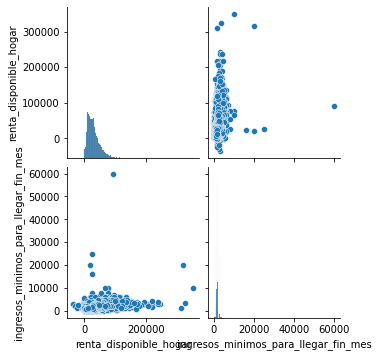

In [12]:
sns.pairplot(df_first)

## Aplicamos algoritmos de clustering

Empezamos aplicando el algoritmo `k-means`:

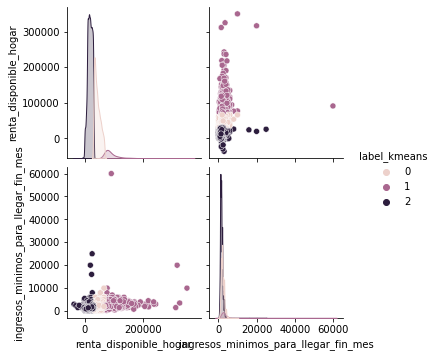

In [13]:
df_first = add_clustering_labels(
    df_first,
    compute_kmeans, 
    parameters = {"number_clusters": 3},
    new_label_name = "label_kmeans"
)
sns.pairplot(df_first, hue = "label_kmeans")

Ahora aplicamos `dbscan` para la clusterización:

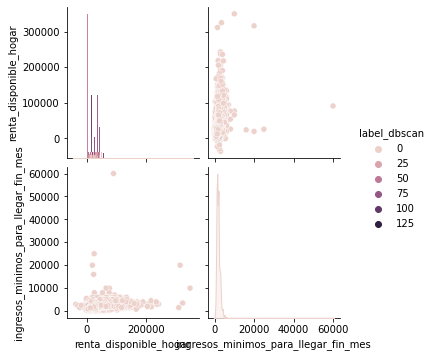

In [14]:
df_first = add_clustering_labels(
    df_first,
    compute_dbscan,
    parameters = {"eps": 0.3, "min_samples": 2},
    new_label_name = "label_dbscan",
    exclude_columns = ["label_kmeans"]
) 
sns.pairplot(df_first, hue = "label_dbscan")